Original X_all shape: (305824, 20, 64)
Original y_all shape: (305824,)

After 65/35 Split:
X_train shape: (198785, 20, 64)
y_train shape: (198785,)
X_test shape: (107039, 20, 64)
y_test shape: (107039,)

--- Training LSTM Model ---
Epoch 1/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 136s 23ms/step - loss: 34.7701 - val_loss: 2.9742
Epoch 2/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - loss: 10.9162 - val_loss: 2.7962
Epoch 3/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 135s 22ms/step - loss: 6.8589 - val_loss: 2.2371
Epoch 4/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 126s 22ms/step - loss: 5.6352 - val_loss: 1.4046
Epoch 5/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 141s 22ms/step - loss: 5.0046 - val_loss: 1.8241
Epoch 6/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - loss: 4.6053 - val_loss: 1.9214
Epoch 7/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 124s 22ms/step - loss: 4.4365 - val_loss: 2.2332
Epoch 8/20
5591/5591 ━━━━━━━━━━━━━━━━━━━━ 143s 22ms/step - loss: 4.2491 - val_loss: 2.2013
Epoch 9/20
5591/5591 ━━━━━━━━━━━━━━━━━

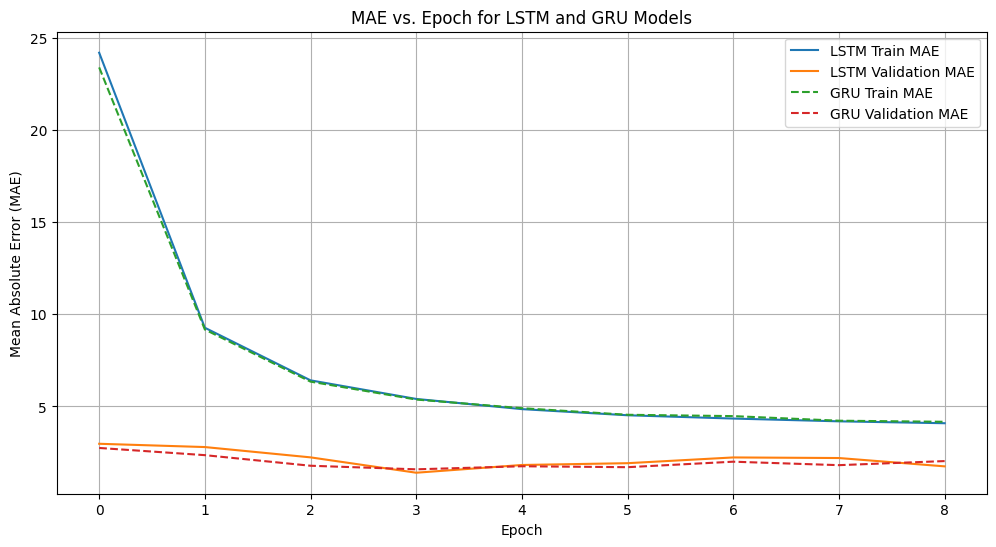

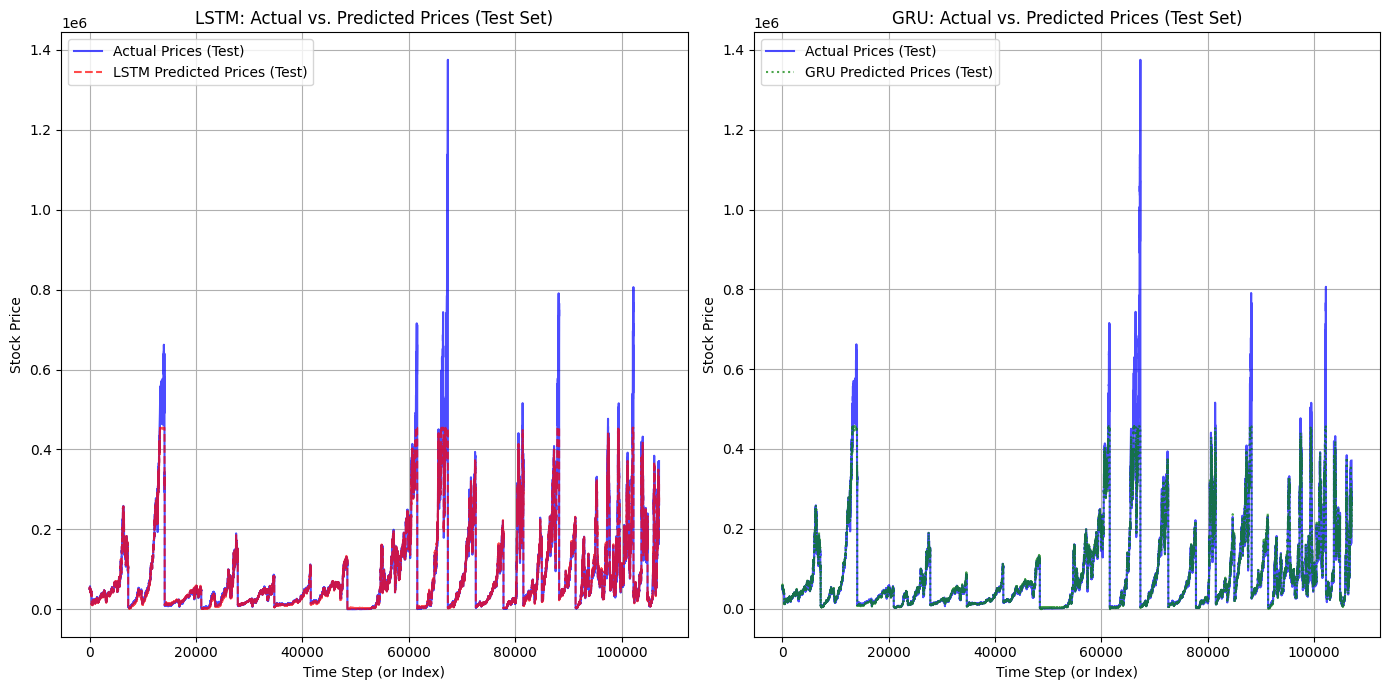

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Required if you scaled your y (target) values


# --- 1. Set Seeding for Reproducibility ⚙️ ---
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)


# --- 2. Data Splitting (65% Train, 35% Test) 📊 ---
print(f"Original X_all shape: {X_all.shape}")
print(f"Original y_all shape: {y_all.shape}")

split_point = int(len(X_all) * 0.65)

X_train, X_test = X_all[:split_point], X_all[split_point:]
y_train, y_test = y_all[:split_point], y_all[split_point:]

print(f"\nAfter 65/35 Split:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


# --- 3. Define Metric Calculation Functions ✅ ---

def calculate_mape(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = y_true.flatten(), y_pred.flatten()
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100

def calculate_directional_accuracy(y_true, y_pred, y_previous_actual):
    """
    Calculates Directional Accuracy.
    Compares if the predicted direction of change matches the actual direction of change.
    Assumes y_true, y_pred, and y_previous_actual are aligned time series.
    """
    y_true, y_pred, y_previous_actual = y_true.flatten(), y_pred.flatten(), y_previous_actual.flatten()

    min_len = min(len(y_true), len(y_pred), len(y_previous_actual))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    y_previous_actual = y_previous_actual[:min_len]

    actual_direction = np.sign(y_true - y_previous_actual)
    predicted_direction = np.sign(y_pred - y_previous_actual)

    correct_predictions = np.sum(actual_direction == predicted_direction)
    total_predictions = len(y_true)

    if total_predictions == 0:
        return 0.0
    return (correct_predictions / total_predictions) * 100

def print_metrics(model_name, y_true_orig, y_pred_orig, y_previous_actual_orig, dataset_type):
    """Helper function to print all metrics."""
    r2 = r2_score(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mape = calculate_mape(y_true_orig, y_pred_orig)
    da = calculate_directional_accuracy(y_true_orig, y_pred_orig, y_previous_actual_orig)

    print(f"\n--- {model_name} {dataset_type} Metrics ---")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Directional Accuracy: {da:.2f}%")


# --- 4. Model Definition, Training, and Prediction (LSTM & GRU) ---

input_shape = (X_train.shape[1], X_train.shape[2]) # (timesteps, features)

# Define EarlyStopping callback
# It will stop training if validation loss doesn't improve for 'patience' epochs.
# 'monitor' is the metric to watch (validation loss in this case).
# 'mode' is 'min' because we want to minimize loss.
# 'restore_best_weights' ensures the model loads weights from the epoch with the best performance.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5, # Number of epochs with no improvement after which training will be stopped.
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# --- LSTM Model ---
print("\n--- Training LSTM Model ---")
lstm_model = keras.Sequential([
    layers.LSTM(units=50, return_sequences=True, input_shape=input_shape),
    layers.Dropout(0.2),
    layers.LSTM(units=50, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mae')
# Fit the model with EarlyStopping and max epochs = 20
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=20, # Max epochs set to 20
    batch_size=32,
    validation_split=0.1, # Use 10% of training data for validation
    callbacks=[early_stopping_callback], # Add the early stopping callback
    verbose=1
)

y_train_pred_lstm_scaled = lstm_model.predict(X_train)
y_test_pred_lstm_scaled = lstm_model.predict(X_test)


# --- GRU Model ---
print("\n--- Training GRU Model ---")
gru_model = keras.Sequential([
    layers.GRU(units=50, return_sequences=True, input_shape=input_shape),
    layers.Dropout(0.2),
    layers.GRU(units=50, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=1)
])

gru_model.compile(optimizer='adam', loss='mae')
# Fit the model with EarlyStopping and max epochs = 20
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=20, # Max epochs set to 20
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping_callback],
    verbose=1
)

y_train_pred_gru_scaled = gru_model.predict(X_train)
y_test_pred_gru_scaled = gru_model.predict(X_test)


# --- 5. Inverse Transform Scaled Data for Metric Calculation ---
# You MUST ensure 'scaler_y' (for target values) is accessible and fitted from your preprocessing.
# If you did not scale y, remove or comment out the inverse_transform lines.

try:
    # Assuming y was scaled using a scaler named 'scaler_y'
    # Make sure scaler_y is initialized and fitted *before* this point
    # For example, if using MinMaxScaler:
    # scaler_y = MinMaxScaler()
    # y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    # y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    # Fit the scaler on the training target data before inverse transforming
    if 'scaler_y' not in locals():
        print("\nNote: 'scaler_y' not found. Initializing MinMaxScaler and fitting on y_train.")
        scaler_y = MinMaxScaler()
        # Assuming y_train is 1D, reshape for scaler
        scaler_y.fit(y_train.reshape(-1, 1))
    elif not hasattr(scaler_y, 'data_min_'): # Check if scaler is fitted (MinMaxScaler specific check)
        print("\nNote: 'scaler_y' found but not fitted. Fitting on y_train.")
        # Assuming y_train is 1D, reshape for scaler
        scaler_y.fit(y_train.reshape(-1, 1))


    y_train_original_scale = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test_original_scale = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    y_train_pred_lstm_original_scale = scaler_y.inverse_transform(y_train_pred_lstm_scaled)
    y_test_pred_lstm_original_scale = scaler_y.inverse_transform(y_test_pred_lstm_scaled)
    y_train_pred_gru_original_scale = scaler_y.inverse_transform(y_train_pred_gru_scaled)
    y_test_pred_gru_original_scale = scaler_y.inverse_transform(y_test_pred_gru_scaled)
    print("\nInverse transformed predictions and true values for metrics.")
except NameError:
    print("\nWarning: `scaler_y` not found and could not be initialized/fitted. Assuming y values were not scaled or using raw values directly.")
    y_train_original_scale = y_train
    y_test_original_scale = y_test
    y_train_pred_lstm_original_scale = y_train_pred_lstm_scaled
    y_test_pred_lstm_original_scale = y_test_pred_lstm_scaled
    y_train_pred_gru_original_scale = y_train_pred_gru_scaled
    y_test_pred_gru_original_scale = y_test_pred_gru_scaled
except AttributeError as e:
     print(f"\nWarning: An AttributeError occurred, possibly related to scaler_y: {e}. Assuming y values were not scaled or using raw values directly.")
     y_train_original_scale = y_train
     y_test_original_scale = y_test
     y_train_pred_lstm_original_scale = y_train_pred_lstm_scaled
     y_test_pred_lstm_original_scale = y_test_pred_lstm_scaled
     y_train_pred_gru_original_scale = y_train_pred_gru_scaled
     y_test_pred_gru_original_scale = y_test_pred_gru_scaled


# --- IMPORTANT: Obtain `previous_actual_prices` for Directional Accuracy ---
# This is critical. You need the actual 'Close' price from the day *before*
# each corresponding 'Next_Close' (y_true) in your train and test sets.
# This value should come from your original, unscaled feature data (or inverse transformed X).
# YOU MUST REPLACE THESE WITH YOUR PROPERLY DERIVED ACTUAL DATA from your original dataset.

# Dummy example for now (replace with your actual logic):
# This assumes that the 'previous_actual_prices' can be approximated by the 'current' y_true shifted.
# This approximation is for making the code runnable; a precise implementation needs your data's original structure.
previous_actual_prices_train_flat = np.concatenate(([y_train_original_scale[0][0]], y_train_original_scale[:-1, 0])).flatten()
previous_actual_prices_test_flat = np.concatenate(([y_test_original_scale[0][0]], y_test_original_scale[:-1, 0])).flatten()


# --- 6. Print Metrics for Both Training and Testing Sets ---

# LSTM Metrics
print_metrics("LSTM", y_train_original_scale, y_train_pred_lstm_original_scale, previous_actual_prices_train_flat, "Train")
print_metrics("LSTM", y_test_original_scale, y_test_pred_lstm_original_scale, previous_actual_prices_test_flat, "Test")

# GRU Metrics
print_metrics("GRU", y_train_original_scale, y_train_pred_gru_original_scale, previous_actual_prices_train_flat, "Train")
print_metrics("GRU", y_test_original_scale, y_test_pred_gru_original_scale, previous_actual_prices_test_flat, "Test")


# --- 7. Plot MAE vs. Epoch Graph 📈 ---

plt.figure(figsize=(12, 6))

plt.plot(lstm_history.history['loss'], label='LSTM Train MAE')
if 'val_loss' in lstm_history.history:
    plt.plot(lstm_history.history['val_loss'], label='LSTM Validation MAE')

plt.plot(gru_history.history['loss'], label='GRU Train MAE', linestyle='--')
if 'val_loss' in gru_history.history:
    plt.plot(gru_history.history['val_loss'], label='GRU Validation MAE', linestyle='--')

plt.title('MAE vs. Epoch for LSTM and GRU Models')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

# --- 8. Plot Predicted vs. Actual Graph (Test Set) 📉 ---

plt.figure(figsize=(14, 7))

# Plot for LSTM
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(y_test_original_scale, label='Actual Prices (Test)', color='blue', alpha=0.7)
plt.plot(y_test_pred_lstm_original_scale, label='LSTM Predicted Prices (Test)', color='red', linestyle='--', alpha=0.7)
plt.title('LSTM: Actual vs. Predicted Prices (Test Set)')
plt.xlabel('Time Step (or Index)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Plot for GRU
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(y_test_original_scale, label='Actual Prices (Test)', color='blue', alpha=0.7)
plt.plot(y_test_pred_gru_original_scale, label='GRU Predicted Prices (Test)', color='green', linestyle=':', alpha=0.7)
plt.title('GRU: Actual vs. Predicted Prices (Test Set)')
plt.xlabel('Time Step (or Index)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()